In [1]:
import sys, os
import sparse
import xsimlab as xs
import xarray as xr
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature

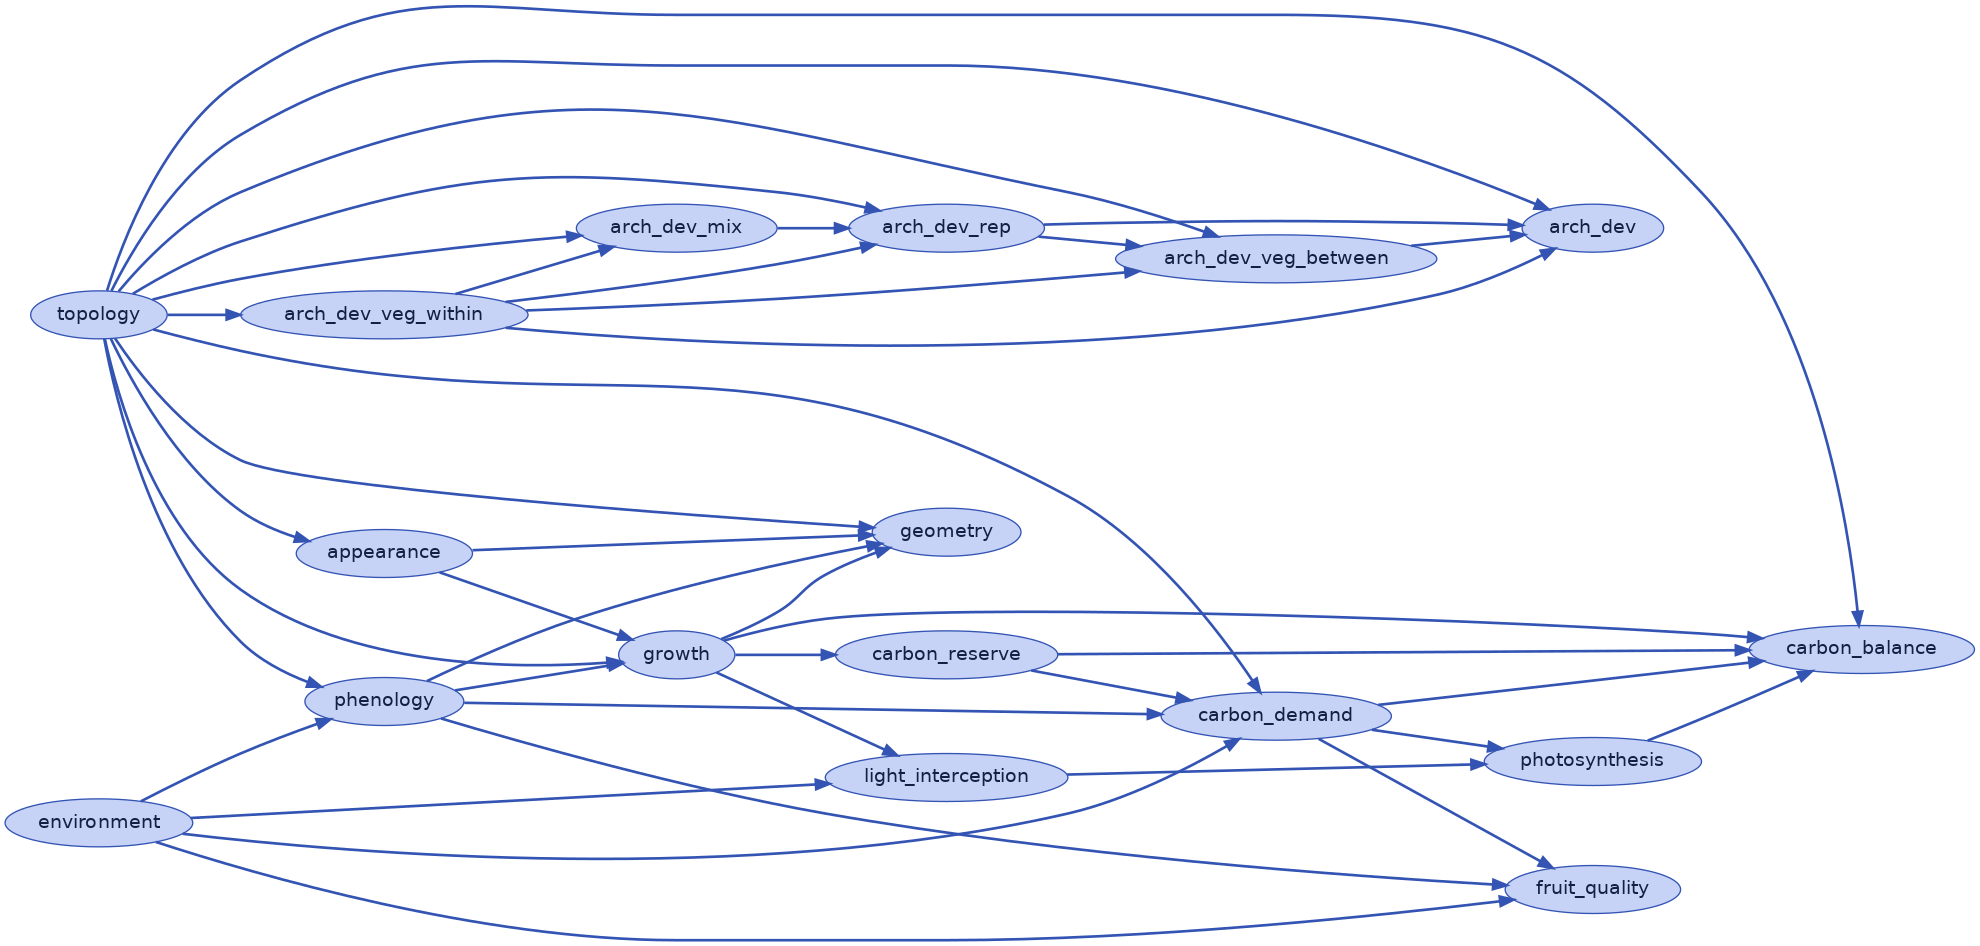

In [3]:
model.visualize()

In [4]:
# model = model.drop_processes(['light_interception', 'photosynthesis', 'carbon_reserves', 'carbon_demand', 'carbon_balance', 'fruit_quality'])
model = model.drop_processes(['geometry'])
model.visualize()

SyntaxError: invalid syntax (<ipython-input-4-924b99d9db2c>, line 1)

In [ ]:
tree = pd.DataFrame({
    'id': [0, 1],
    'parent_id': [np.nan, 0],
    'cycle': [3, 3],
    'is_apical': [1, 1],
    'appearance_month': [3, 3],
    'ancestor_nature': [0, 0],
    'ancestor_is_apical': [1, 1]
})
tree

In [ ]:
ds = vmlab.create_setup(
    model,
    initial_tree_df=None,
    start_date='2002-04-01',
    end_date='2005-06-30',
    setup_toml='../share/setup/vmango.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 0,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214
        },
        'geometry__interpretation_freq': 3
    },
    output_vars=None
)

In [ ]:
sw = SceneWidget(size_world=2.5)
sw

In [ ]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

In [ ]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().plot.bar()

In [ ]:
pot_burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
pot_burst_date.count().to_dataframe().plot.bar()

In [ ]:
pot_flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
pot_flowering_date.count().to_dataframe().plot.bar()

In [ ]:
topology__nb_inflo = ds_out.topology__nb_inflo.groupby(ds_out.topology__nb_inflo)
topology__nb_inflo.sum().to_dataframe().plot.bar()

In [ ]:
nb_fruit = ds_out.topology__nb_fruit.groupby(ds_out.topology__nb_fruit)
nb_fruit.sum().to_dataframe().plot.bar()

In [ ]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
nb_children = nb_children[nb_children > 0]
nb_children.groupby(nb_children).count().to_dataframe().plot.bar()

In [ ]:
nb_children = xr.DataArray(ds_out.arch_dev__pot_has_apical_child + ds_out.arch_dev__pot_nb_lateral_children, name='nb_children')
ds_children = xr.Dataset({
    'nb_children':  nb_children[nb_children > 0], 
    'cycle': ds_out.topology__cycle[nb_children > 0]
})
ds_children

In [ ]:
ds_children.groupby(ds_children.cycle).sum().to_dataframe().plot.bar()

In [ ]:
ds_out.appearance__final_length_inflos.values.tolist()